In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [67]:
images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob.glob('test_images/test*.jpg')]

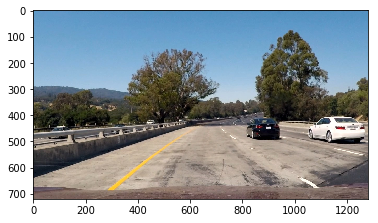

In [68]:
plt.imshow(images[0])

In [4]:
def plot_images(images):
    image_count = len(images)
    fig = plt.figure(figsize=(24, 12))
    for i, image in enumerate(images):
        tmp = fig.add_subplot(1, image_count, i+1)
        tmp.imshow(image)
    plt.show()

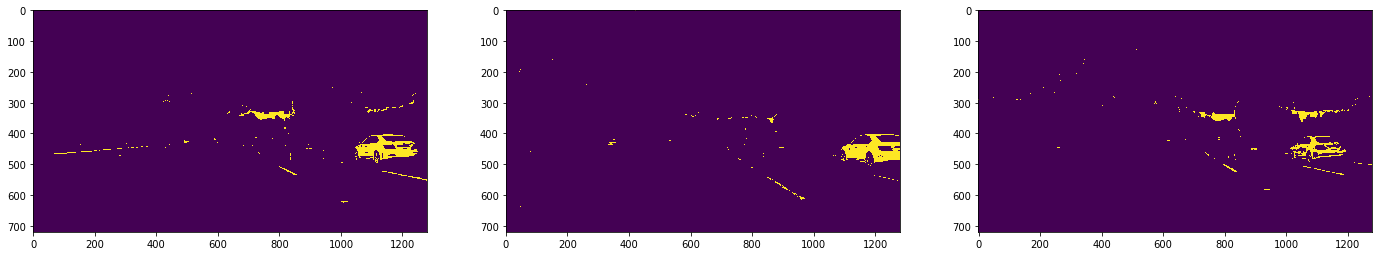

In [209]:
def get_white(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = [hsv[:, :, i] for i in range(3)]
    binary = np.zeros_like(V)
    # Yellow
    binary[((V > 190) & (S <= 20))] = 1
    return binary

plot_images([get_white(img) for img in images[3:]])


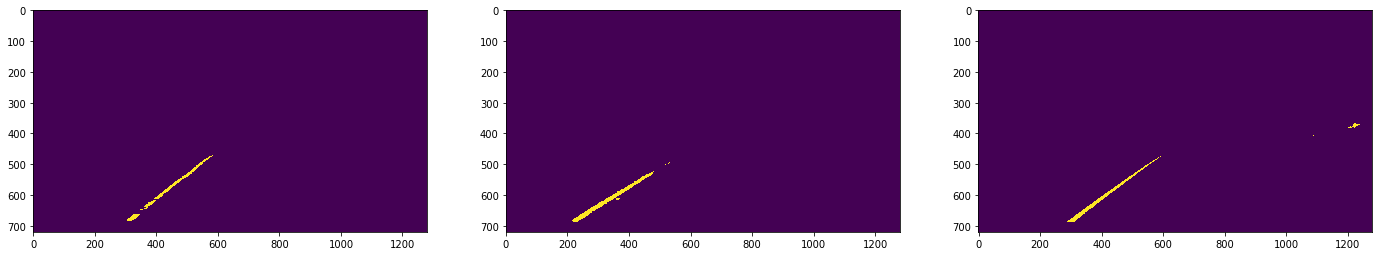

In [211]:
def get_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = [hsv[:, :, i] for i in range(3)]
    binary = np.zeros_like(V)
    # Yellow
    binary[((H > 90) & (H < 110) & (S > 90) & (V > 200))] = 1
    return binary
plot_images([get_yellow(img) for img in images[3:]])

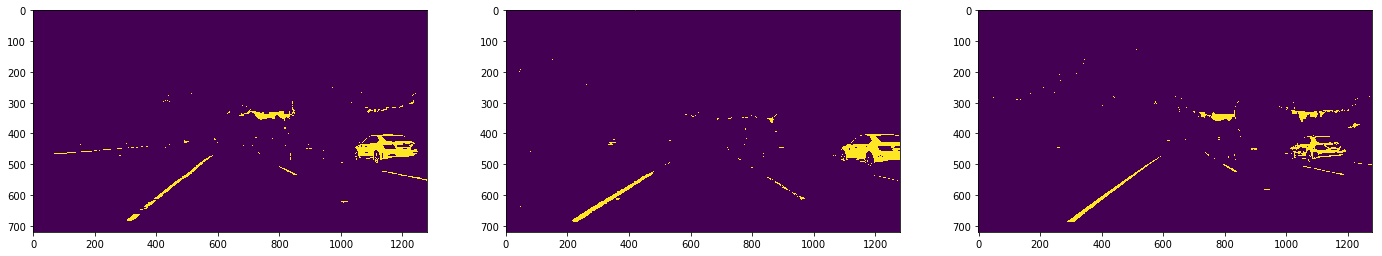

In [210]:
def get_hsv_line(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = [hsv[:, :, i] for i in range(3)]
    binary = np.zeros_like(V)
    # White & Yellow
    binary[((V > 190) & (S <= 20)) | ((H > 90) & (H < 110) & (S > 90) & (V > 200))] = 1
    return binary

plot_images([get_hsv_line(img) for img in images[3:]])

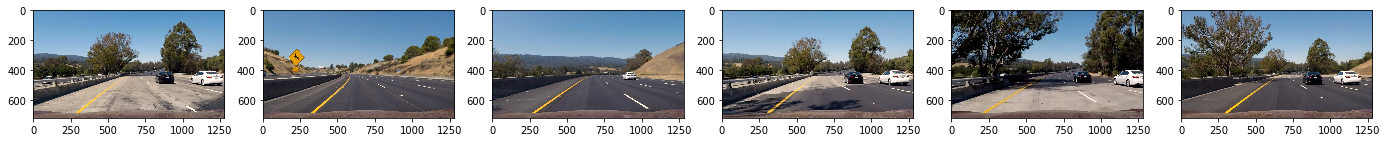

In [178]:

plot_images([img for img in images])

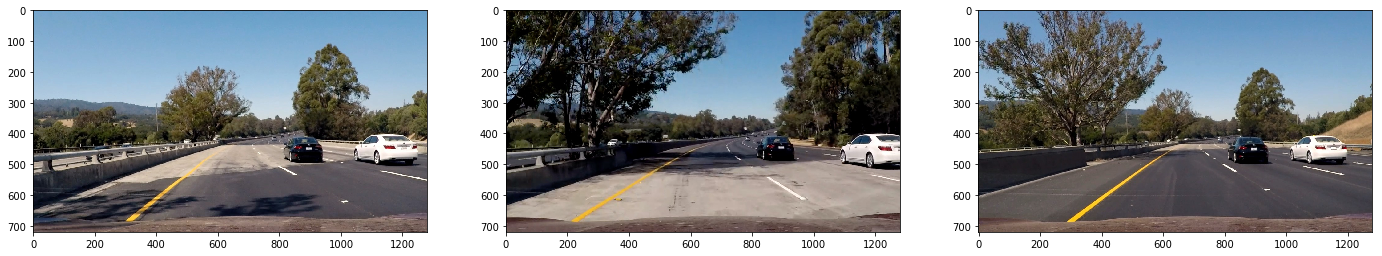

In [43]:
plot_images([img for img in images[3:]])

In [104]:
def get_edges(image, threshold=220):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))

    thresh_min = 50
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary



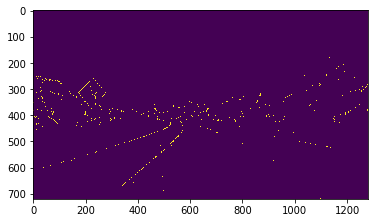

In [111]:
plt.imshow(get_edges(images[1]))

In [ ]:
plt.imshow(get_edges(images[1]))

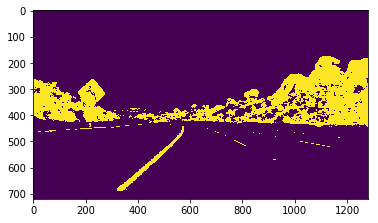

In [112]:
plt.imshow(get_hsv_line(images[1]))

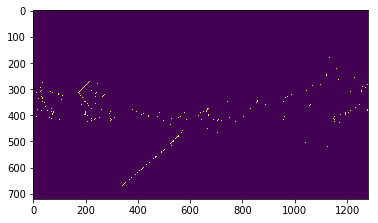

In [115]:
plt.imshow(np.minimum(get_edges(images[1]),get_hsv_line(images[1])))

In [127]:
BOTTOM_LEFT = (265, 700)
BOTTOM_RIGHT = (1130, 700)
TOP_LEFT = (510, 525)
TOP_RIGHT = (845, 525)

SRC = np.float32([
    BOTTOM_LEFT,
    BOTTOM_RIGHT,
    TOP_LEFT,
    TOP_RIGHT
])

DST = np.float32([
    BOTTOM_LEFT,
    BOTTOM_RIGHT,
    (265, 525),
    (1130, 525),
])

M = cv2.getPerspectiveTransform(SRC, DST)
M_INV = cv2.getPerspectiveTransform(DST, SRC)

def first_person_to_birds_eye_view(image):
    undistorted_image = image
    warped = cv2.warpPerspective(undistorted_image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

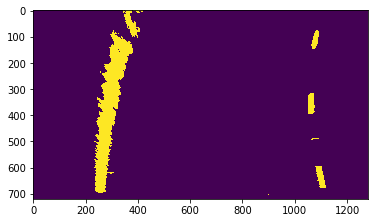

In [121]:
binary_warped = get_hsv_line(first_person_to_birds_eye_view(images[2]))
plt.imshow(binary_warped)

In [122]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = get_hsv_line(first_person_to_birds_eye_view(images[2]))
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

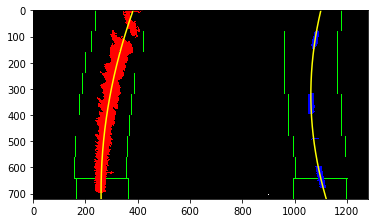

In [123]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

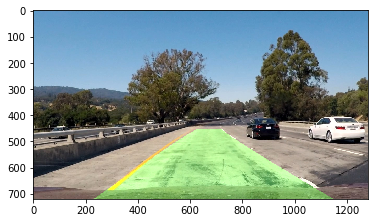

In [130]:
undist = images[0]
image = images[0]
warped = binary_warped
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_INV, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [136]:
pts[0][200]

array([ 321.80804855,  200.        ])

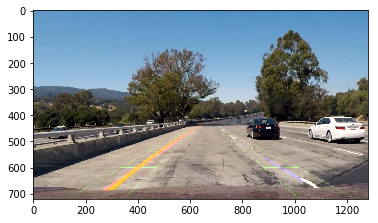

In [138]:
newwarp = cv2.warpPerspective(out_img, M_INV, (undist.shape[1], undist.shape[0])) 
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)